In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

import regreg.api as rr

from selectinf.group_lasso_query import (group_lasso, split_group_lasso)

from selectinf.Simulation.instance import logistic_group_instance

from selectinf.Simulation.test_logistic_group_lasso import (calculate_F1_score,
                                                            naive_inference,
                                                            randomization_inference,
                                                            randomization_inference_fast,
                                                            split_inference, data_splitting)

/Users/yilingh/Desktop/PhD/SI_Codes/G_LASSO_Final/PoSI-GroupLASSO/env3/lib/python3.10/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')


In [2]:
def comparison_logistic(range):
    """
        Compare to R randomized lasso
        """
    n = 500
    p = 20
    signal_fac = 0.1
    sigma = 2
    rho = 0.5
    proportion = 0.5
    randomizer_scale = 1.
    full_dispersion = True
    level = 0.90

    # Operating characteristics
    oper_char = {}
    oper_char["proportion"] = []
    oper_char["n"] = []
    oper_char["coverage rate"] = []
    oper_char["avg length"] = []
    oper_char["method"] = []
    oper_char["F1 score"] = []
    
    for n in [200, 350, 500]:
        for proportion in [0.5, 0.6, 0.7]:
        #for proportion in [0.3, 0.4, 0.5, 0.6, 0.7]:  # [0.01, 0.03, 0.06, 0.1]:
            for i in range:
                np.random.seed(i)
    
                inst, const, const_split = logistic_group_instance, group_lasso.logistic, \
                                           split_group_lasso.logistic
                signal = np.sqrt(signal_fac * 2 * np.log(p))
                signal_str = str(np.round(signal, decimals=2))
    
                while True:  # run until we get some selection
                    groups = np.arange(5).repeat(4)
                    X, Y, beta = inst(n=n,
                                      p=p,
                                      signal=signal,
                                      sgroup=0,
                                      groups=groups,
                                      ndiscrete=5,
                                      nlevels=5,
                                      sdiscrete=2,  # s-3, # How many discrete rvs are not null
                                      equicorrelated=False,
                                      rho=rho,
                                      random_signs=True)[:3]
                    # print(X)
    
                    n, p = X.shape
    
                    noselection = False  # flag for a certain method having an empty selected set
    
                    if not noselection:
                        # MLE inference
                        coverage, length, beta_target, nonzero, conf_low, conf_up = \
                            randomization_inference_fast(X=X, Y=Y, n=n, p=p, 
                                                         proportion=proportion,
                                                         beta=beta, groups=groups)
                        noselection = (coverage is None)
    
                    if not noselection:
                        # data splitting
                        coverage_ds, lengths_ds, conf_low_ds, conf_up_ds, nonzero_ds, beta_target_ds = \
                            data_splitting(X=X, Y=Y, n=n, p=p, beta=beta, groups=groups,
                                           proportion=proportion, level=0.9)
                        noselection = (coverage_ds is None)
    
                    if not noselection:
                        # naive inference
                        coverage_naive, lengths_naive, nonzero_naive, conf_low_naive, conf_up_naive, \
                        beta_target_naive = \
                            naive_inference(X=X, Y=Y, groups=groups,
                                            beta=beta, const=const,
                                            n=n, level=level)
                        noselection = (coverage_naive is None)
    
                    if not noselection:
                        # F1 scores
                        F1 = calculate_F1_score(beta, selection=nonzero)
                        F1_ds = calculate_F1_score(beta, selection=nonzero_ds)
                        F1_naive = calculate_F1_score(beta, selection=nonzero_naive)
    
                        # MLE coverage
                        oper_char["n"].append(n)
                        oper_char["proportion"].append(proportion)
                        oper_char["coverage rate"].append(np.mean(coverage))
                        oper_char["avg length"].append(np.mean(length))
                        oper_char["F1 score"].append(F1)
                        oper_char["method"].append('MLE')
    
                        # Data splitting coverage
                        oper_char["n"].append(n)
                        oper_char["proportion"].append(proportion)
                        oper_char["coverage rate"].append(np.mean(coverage_ds))
                        oper_char["avg length"].append(np.mean(lengths_ds))
                        oper_char["F1 score"].append(F1_ds)
                        oper_char["method"].append('Data splitting')
    
                        # Naive coverage
                        oper_char["n"].append(n)
                        oper_char["proportion"].append(proportion)
                        oper_char["coverage rate"].append(np.mean(coverage_naive))
                        oper_char["avg length"].append(np.mean(lengths_naive))
                        oper_char["F1 score"].append(F1_naive)
                        oper_char["method"].append('Naive')
    
                        break  # Go to next iteration if we have some selection

    oper_char_df = pd.DataFrame.from_dict(oper_char)

    print("task done")
    return oper_char_df

In [3]:
oper_char_df = comparison_logistic(range(0,500))

Naive selection []
Naive selection [1]


/Users/yilingh/Desktop/PhD/SI_Codes/G_LASSO_Final/PoSI-GroupLASSO/selectinf/Simulation/test_logistic_group_lasso.py:30: RuntimeWarning: invalid value encountered in long_scalars
  recall = (nonzero_true * selection).sum() / nonzero_true.sum()


Naive selection [0, 1]


/Users/yilingh/Desktop/PhD/SI_Codes/G_LASSO_Final/PoSI-GroupLASSO/selectinf/Simulation/test_logistic_group_lasso.py:30: RuntimeWarning: invalid value encountered in long_scalars
  recall = (nonzero_true * selection).sum() / nonzero_true.sum()


Naive selection [0]


/Users/yilingh/Desktop/PhD/SI_Codes/G_LASSO_Final/PoSI-GroupLASSO/selectinf/Simulation/test_logistic_group_lasso.py:30: RuntimeWarning: invalid value encountered in long_scalars
  recall = (nonzero_true * selection).sum() / nonzero_true.sum()


Naive selection [4]


/Users/yilingh/Desktop/PhD/SI_Codes/G_LASSO_Final/PoSI-GroupLASSO/selectinf/Simulation/test_logistic_group_lasso.py:30: RuntimeWarning: invalid value encountered in long_scalars
  recall = (nonzero_true * selection).sum() / nonzero_true.sum()
/Users/yilingh/Desktop/PhD/SI_Codes/G_LASSO_Final/PoSI-GroupLASSO/selectinf/Simulation/test_logistic_group_lasso.py:30: RuntimeWarning: invalid value encountered in long_scalars
  recall = (nonzero_true * selection).sum() / nonzero_true.sum()


Naive selection [2]
Naive selection [1, 4]


/Users/yilingh/Desktop/PhD/SI_Codes/G_LASSO_Final/PoSI-GroupLASSO/selectinf/Simulation/test_logistic_group_lasso.py:30: RuntimeWarning: invalid value encountered in long_scalars
  recall = (nonzero_true * selection).sum() / nonzero_true.sum()


Naive selection [3]
Naive selection []


/Users/yilingh/Desktop/PhD/SI_Codes/G_LASSO_Final/PoSI-GroupLASSO/selectinf/Simulation/test_logistic_group_lasso.py:30: RuntimeWarning: invalid value encountered in long_scalars
  recall = (nonzero_true * selection).sum() / nonzero_true.sum()


Naive selection [1]


/Users/yilingh/Desktop/PhD/SI_Codes/G_LASSO_Final/PoSI-GroupLASSO/selectinf/Simulation/test_logistic_group_lasso.py:30: RuntimeWarning: invalid value encountered in long_scalars
  recall = (nonzero_true * selection).sum() / nonzero_true.sum()


Naive selection [3]
Naive selection [3]


/Users/yilingh/Desktop/PhD/SI_Codes/G_LASSO_Final/PoSI-GroupLASSO/selectinf/Simulation/test_logistic_group_lasso.py:30: RuntimeWarning: invalid value encountered in long_scalars
  recall = (nonzero_true * selection).sum() / nonzero_true.sum()
/Users/yilingh/Desktop/PhD/SI_Codes/G_LASSO_Final/PoSI-GroupLASSO/selectinf/Simulation/test_logistic_group_lasso.py:30: RuntimeWarning: invalid value encountered in long_scalars
  recall = (nonzero_true * selection).sum() / nonzero_true.sum()


Naive selection [1]


/Users/yilingh/Desktop/PhD/SI_Codes/G_LASSO_Final/PoSI-GroupLASSO/selectinf/Simulation/test_logistic_group_lasso.py:30: RuntimeWarning: invalid value encountered in long_scalars
  recall = (nonzero_true * selection).sum() / nonzero_true.sum()


Naive selection []
Naive selection []
Naive selection []
Naive selection [4]


/Users/yilingh/Desktop/PhD/SI_Codes/G_LASSO_Final/PoSI-GroupLASSO/selectinf/Simulation/test_logistic_group_lasso.py:30: RuntimeWarning: invalid value encountered in long_scalars
  recall = (nonzero_true * selection).sum() / nonzero_true.sum()


Naive selection [2, 3, 4]


/Users/yilingh/Desktop/PhD/SI_Codes/G_LASSO_Final/PoSI-GroupLASSO/selectinf/Simulation/test_logistic_group_lasso.py:30: RuntimeWarning: invalid value encountered in long_scalars
  recall = (nonzero_true * selection).sum() / nonzero_true.sum()


Naive selection [0]


/Users/yilingh/Desktop/PhD/SI_Codes/G_LASSO_Final/PoSI-GroupLASSO/selectinf/Simulation/test_logistic_group_lasso.py:30: RuntimeWarning: invalid value encountered in long_scalars
  recall = (nonzero_true * selection).sum() / nonzero_true.sum()


Naive selection []


KeyboardInterrupt: 

In [64]:
oper_char_df.to_csv("logis_toy_revision.csv", index=None)

In [65]:
def box_plot(oper_char_df, x_axis='p', hue='method', plot_size=False):
    oper_char_df_copy = oper_char_df.copy()
    sns.set_style("white", {'axes.facecolor': 'white', 
                            'axes.grid': True,
                            'axes.linewidth': 2.0,
                            'grid.linestyle': u'--',
                            'grid.linewidth': 4.0,
                            'xtick.major.size': 5.0,
                           })
    #sns.histplot(oper_char_df["sparsity size"])
    #plt.show()
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,9))
    
    if "method" in oper_char_df_copy.columns:
    
        alias = {"MLE": "Proposed", 
                 "Naive": "Naive", 
                 "Data splitting": "Data Splitting"}
        #order = [alias[meth] for meth in order]
        
        oper_char_df_copy['method'] = oper_char_df_copy['method'].map(alias)
        
        my_palette = {"Proposed": "#48c072", 
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}
    
    print("Mean coverage rate/length:")
    print(oper_char_df_copy.groupby([x_axis, hue]).mean())
    
    cov_plot = sns.boxplot(y=oper_char_df_copy["coverage rate"],
                           x=oper_char_df_copy[x_axis],
                           hue=oper_char_df_copy[hue],
                           orient="v", ax=ax1, palette=my_palette)
    
    ax1.set_ylabel("Coverage Rate", fontsize=15)  # remove y label, but keep ticks
    ax1.set_xlabel("n", fontsize=15)
    cov_plot.set_ylim(0., 1.05)
    #plt.tight_layout()
    cov_plot.axhline(y=0.9, color='k', linestyle='--', linewidth=1)
    
    filtered_data = oper_char_df_copy[~oper_char_df_copy['method'].isin(['Naive'])]

    len_plot = sns.boxplot(y=filtered_data["avg length"],
                           x=filtered_data[x_axis],
                           hue=filtered_data[hue],
                           orient="v", ax=ax2, palette=my_palette)
    ax2.set_ylabel("Average Length", fontsize=15)  # remove y label, but keep ticks
    ax2.set_xlabel("n", fontsize=15)
    
    F1_plot = sns.boxplot(y=filtered_data["F1 score"],
                           x=filtered_data[x_axis],
                           hue=filtered_data[hue],
                           orient="v", ax=ax3, palette=my_palette)
    ax3.set_ylabel("F1 score", fontsize=15)  # remove y label, but keep ticks
    ax3.set_xlabel("n", fontsize=15)

    handles, labels = ax2.get_legend_handles_labels()
    # fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.2)
    
    ax1.tick_params(axis='x', labelsize=15)
    ax1.tick_params(axis='y', labelsize=15)
    ax2.tick_params(axis='x', labelsize=15)
    ax2.tick_params(axis='y', labelsize=15)
    ax3.tick_params(axis='x', labelsize=15)
    ax3.tick_params(axis='y', labelsize=15)
    
    fig.subplots_adjust(bottom=0.2)
    fig.legend(handles, labels, loc='lower center', ncol=4, prop={'size': 15})
    
    F1_plot.legend_.remove()
    cov_plot.legend_.remove()
    len_plot.legend_.remove()

    #plt.suptitle("Changing n,p")
    plt.subplots_adjust(wspace=0.6, hspace=0.5)
    plt.show()

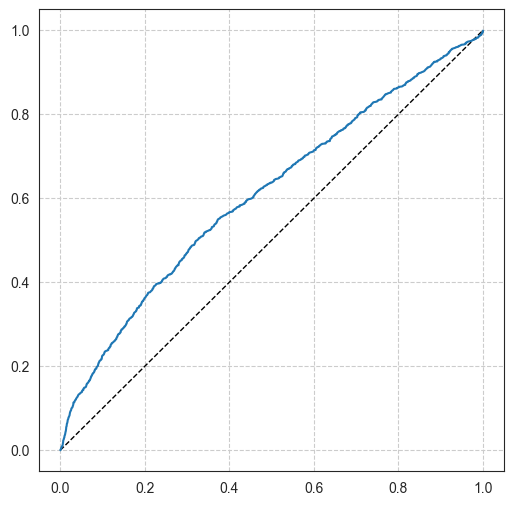

In [66]:
# oper_char = pd.read_csv("logis_ICSA_toy.csv",index_col=None)

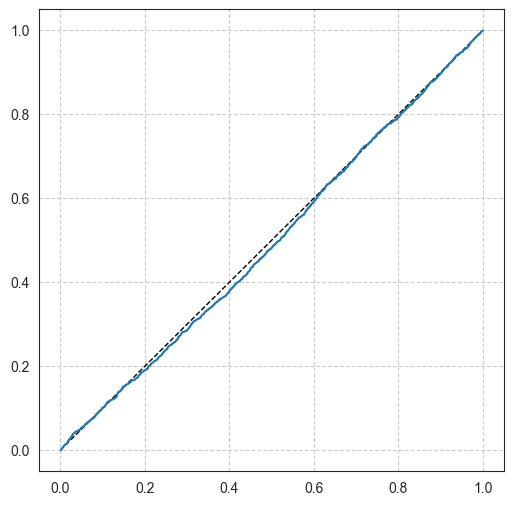

In [67]:
box_plot(oper_char_df, x_axis="n", hue='method', plot_size=False)

# Calculate Mean Operating Characteristics

In [70]:
print(oper_char_df.groupby(["n", "method", "proportion"]).mean())

                               coverage rate  avg length  F1 score
n   method         proportion                                     
200 Data splitting 0.5              0.882158   11.825220  0.452919
                   0.6              0.883767   15.656303  0.408410
                   0.7              0.890233   60.672258  0.385705
    MLE            0.5              0.881617   10.404413  0.455448
                   0.6              0.889783   11.231204  0.434272
                   0.7              0.894292   12.501884  0.396572
    Naive          0.5              0.760800    6.851109  0.336807
                   0.6              0.756717    6.853088  0.335274
                   0.7              0.760133    6.859721  0.340140
350 Data splitting 0.5              0.888117   11.140692  0.456597
                   0.6              0.892408   12.390692  0.456038
                   0.7              0.887542   14.253441  0.426658
    MLE            0.5              0.881392   10.340474  0.46

In [57]:
oper_char_df

In [58]:
def get_table_dfs(oper_char_df):
    data = oper_char_df.copy()
    # Define the desired order for the 'method' column
    method_order = ['MLE', 'Data splitting', 'Naive']
    data['method'] = pd.Categorical(data['method'], categories=method_order, ordered=True)
    
    dfs = []
    for metric in ['coverage rate', 'avg length', 'F1 score']:
        
        # Grouping by 'n' and 'method', and then calculating the mean of 'coverage rate' for different 'proportion' values
        grouped_data = data.groupby(['n', 'method', 'proportion'])[metric].mean().unstack()
        
        # Resetting index to have 'n' and 'method' as columns again for clarity
        grouped_data_reset = grouped_data.reset_index()
        
        dfs.append(grouped_data_reset) 
    
    return dfs[0], dfs[1], dfs[2]

Mean coverage rate/length:
                    proportion  coverage rate  avg length  F1 score
n   method                                                         
200 Data Splitting         0.7       0.896667   87.866804  0.566667
    Naive                  0.7       0.863750    7.326486  0.578000
    Proposed               0.7       0.910000   12.973716  0.522000
350 Data Splitting         0.7       0.891917   14.293806  0.493671
    Naive                  0.7       0.832500    7.149163  0.537333
    Proposed               0.7       0.884583   12.715731  0.523429
500 Data Splitting         0.7       0.880500   13.988603  0.539429
    Naive                  0.7       0.786250    6.926707  0.535333
    Proposed               0.7       0.892417   12.835294  0.556952


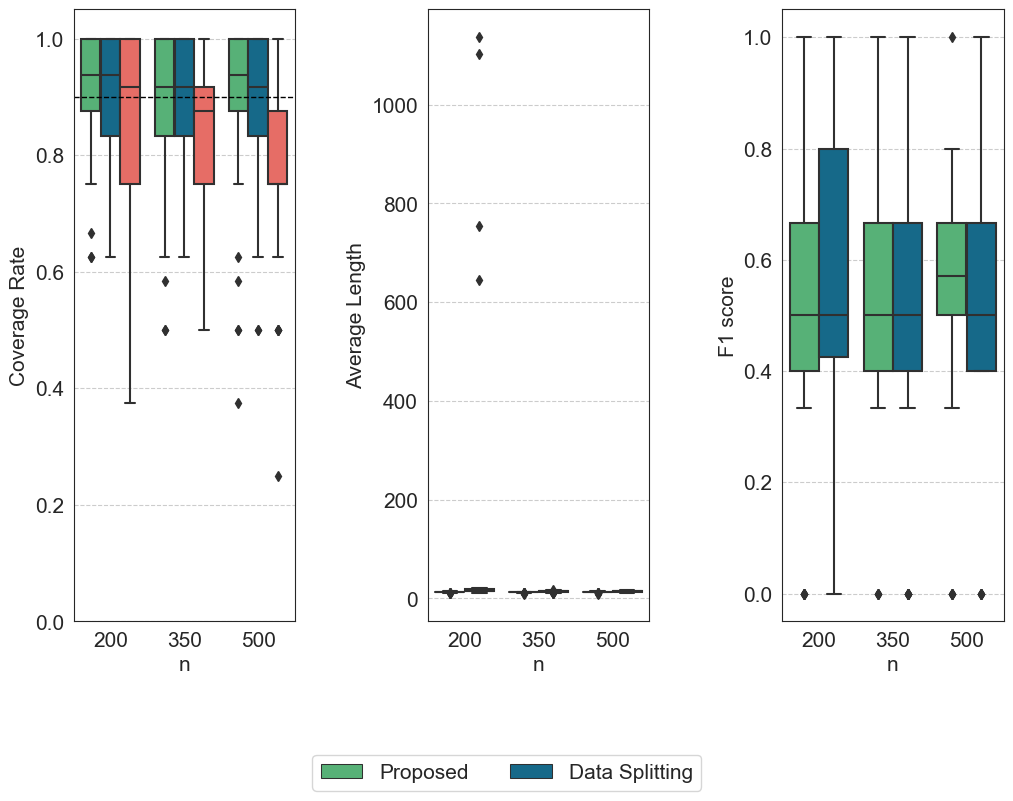

In [59]:
cov_df, len_df, F1_df = get_table_dfs(oper_char_df)

In [74]:
cov_df

proportion,n,method,0.5,0.6,0.7
0,200,MLE,0.881617,0.889783,0.894292
1,200,Data splitting,0.882158,0.883767,0.890233
2,200,Naive,0.760800,0.756717,0.760133
3,350,MLE,0.881392,0.887617,0.879508
4,350,Data splitting,0.888117,0.892408,0.887542
5,350,Naive,0.754542,0.754708,0.755342
6,500,MLE,0.889008,0.891125,0.882492
7,500,Data splitting,0.892817,0.888342,0.890383
8,500,Naive,0.776167,0.774542,0.774542


In [75]:
len_df

proportion,n,method,0.5,0.6,0.7
0,200,MLE,10.404413,11.231204,12.501884
1,200,Data splitting,11.825220,15.656303,60.672258
2,200,Naive,6.851109,6.853088,6.859721
3,350,MLE,10.340474,11.210432,12.626254
4,350,Data splitting,11.140692,12.390692,14.253441
5,350,Naive,6.783086,6.786166,6.800912
6,500,MLE,10.304283,11.281634,12.672238
7,500,Data splitting,10.917883,11.970559,13.687437
8,500,Naive,6.690891,6.679656,6.701332


In [76]:
F1_df

proportion,n,method,0.5,0.6,0.7
0,200,MLE,0.455448,0.434272,0.396572
1,200,Data splitting,0.452919,0.408410,0.385705
2,200,Naive,0.336807,0.335274,0.340140
3,350,MLE,0.463710,0.429749,0.427552
4,350,Data splitting,0.456597,0.456038,0.426658
5,350,Naive,0.355949,0.360858,0.355801
6,500,MLE,0.462024,0.445467,0.419719
7,500,Data splitting,0.459971,0.441019,0.403686
8,500,Naive,0.325391,0.326582,0.335248


In [77]:
cov_df.to_csv("cov_df.csv", float_format='%.3f', index=None)

In [78]:
len_df.to_csv("len_df.csv", float_format='%.3f', index=None)

In [79]:
F1_df.to_csv("F1_df.csv", float_format='%.3f', index=None)